# Week 4 - Probabilistic Programming with STAN

## Part 1 - Simple STAN model

Hello again. We've finally arrived to STAN - our platform for probabilistic programming!



...the usual imports...

**well, notice the new packages!!**

In [1]:
import numpy as np
import pystan_utils # our own small package with utilities to use with STAN
import matplotlib.pyplot as plt
import random
import pystan

# matplotlib options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

### 1.1. Hello World and variations

Every respectable programming language requires that newcomers start with a small "Hello World" code. Besides being a familiar initial exercise, it also lets you learn a basic tool: how to print something! 

Don't forget. It may be useful for you later, for example for debugging!

We'll do the program for you



In [2]:
Hello_STAN="""
transformed data {
    print("Hello World from STAN");
}
"""

# compile model
sm = pystan.StanModel(model_code=Hello_STAN)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_525af6d7864d89b75150c90990c74893 NOW.


To run the program above in pystan, we need to call the following method. Notice the parameters.

In [20]:
# run inference
fit = sm.sampling(algorithm="Fixed_param", iter=10)

Look carefully at your STAN output. It is NOT in this notebook... you'll have to go to the console to see it! 

Can you control the number of times the sentence "Hello World..." shows up? 

Can you try to print from other STAN code blocks? What are the effects?

The next step is to exchange data TO/FROM your STAN and Python codes, with a trivial model. 

The example below sends one real number to STAN, as data point a, then it gets it sends it back through two values: a single sample, x, from a normal distribution (centered at a); a new variable, b, that simply equals a.

In [21]:
tofrom_STAN="""
data {
    real a;
}
parameters {
    real x;
}
model {  
    x ~ normal(a, 10);
}
generated quantities {
    real b=a;
}
"""

# compile model
sm = pystan.StanModel(model_code=tofrom_STAN)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7384559753dd62ef93c08258136043a7 NOW.


This time, we will use HMC (Hamiltonian Monte Carlo)

In [22]:
# run inference
fit = sm.sampling(data={'a':5}, algorithm="HMC", seed=0, iter=1000)

Take a look at the results (variable fit). 

In [23]:
fit

Inference for Stan model: anon_model_7384559753dd62ef93c08258136043a7.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
x      4.96    0.22   9.69 -13.87  -1.64   5.04  11.26  24.18   2000    1.0
b       5.0     0.0    0.0    5.0    5.0    5.0    5.0    5.0   2000    nan
lp__  -0.47    0.02   0.69  -2.39  -0.59  -0.21  -0.05-6.3e-4    770   1.01

Samples were drawn using HMC at Fri Feb 23 10:46:23 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

Actually, there's still more to it. In fact, STAN didn't just draw a single value x as you can see from the table (look at n_eff, it obtained 2000 draws!). All the 2000 samples are available through fit.extract()

In [24]:
fit.extract()

OrderedDict([('x',
              array([13.34201238,  0.87074243, 26.85161608, ...,  8.05117691,
                     20.8361263 , -7.31079336])),
             ('b', array([5., 5., 5., ..., 5., 5., 5.])),
             ('lp__',
              array([-0.34794585, -0.08525384, -2.38746563, ..., -0.0465484 ,
                     -1.25391448, -0.75777817]))])

Make a histogram for x. What kind of distribution would you expect? ;-)

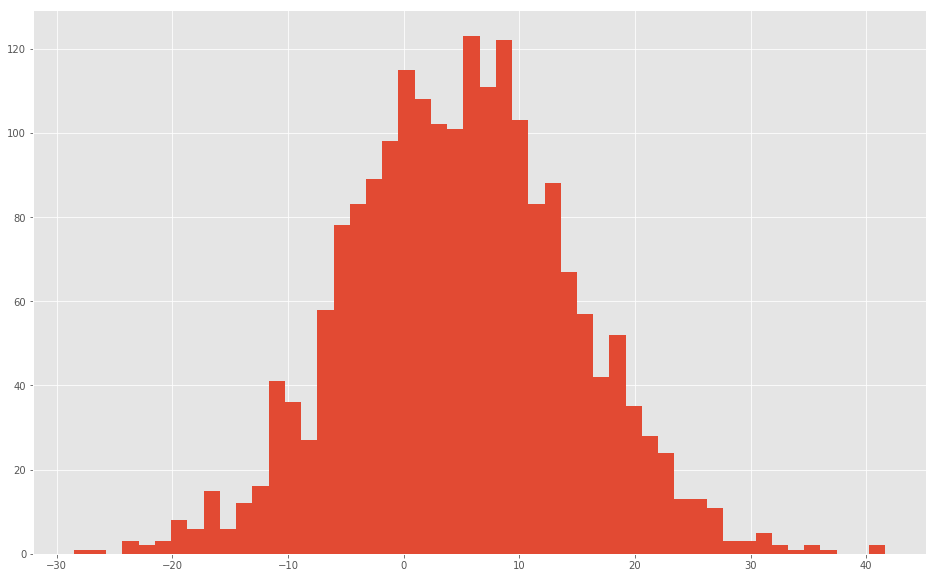

In [25]:
plt.hist(fit.extract()['x'], bins=50);

What's happening is that each single iteration (of 1000) of each single chain (of 4) is drawing one sample. Since STAN only uses data after the first 50% iterations, it becomes 500x4=2000 samples of the same variable. That is why x is not a single value, but instead a distribution. 

Actually you could have used 
>fit.traceplot('x')

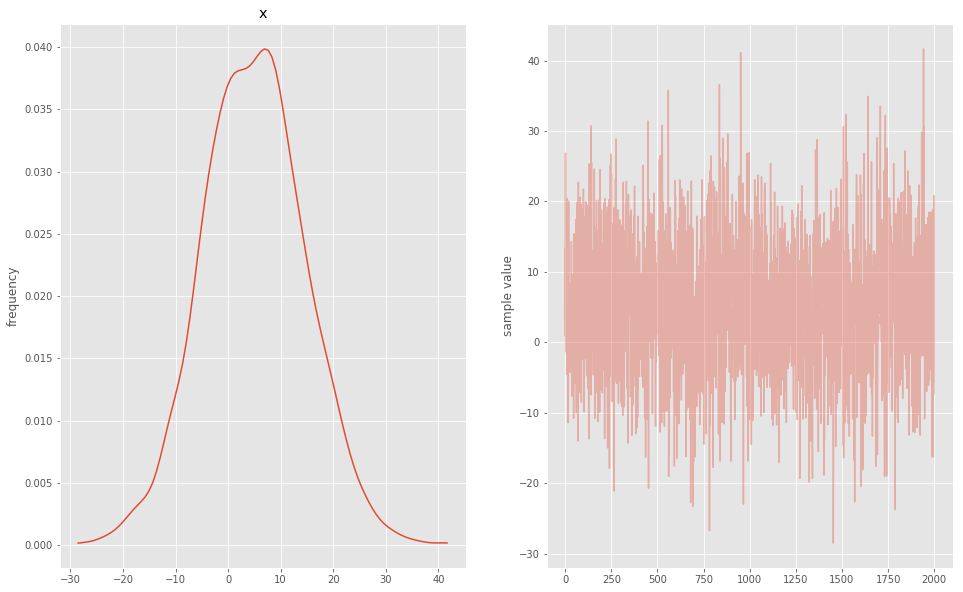

In [26]:
fit.traceplot('x');

Let's ellaborate a bit more with the input/outputs.

In [27]:
simple_STAN="""
data {
    real a;
}
transformed data {
    real b=2*a;
    int c=10;
    print("c=", c, " b=", b); // check this in the console!!!
}
parameters {
    real x;
}
model {
    x ~ normal(a, 10);
}
generated quantities {
    real d=a+c;
    real e=4.0;
}
"""

# compile model
sm = pystan.StanModel(model_code=simple_STAN)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_41595b3176532f7ecea49f20a753d4ef NOW.


Let's run it

In [28]:
# run inference
fit = sm.sampling(data={'a':5}, algorithm="HMC", seed=0, iter=1000)

Notice that the function call returns a value into the 'fit' variable. Do you want to take a look at it? Can you retrieve the value of the parameter 'b'? What about 'd'?

In [29]:
len(fit.extract()['d'])

2000

With one data point at a time, we won't go that far, so it's time to work with vectors...  

In [30]:
simple_vector_STAN="""
data {
    int N;
    vector[N] a;
}
transformed data {
    real b=mean(a);
    print("b=", b); // check this in the console!!!
}
parameters {
    real x;
    real y;
}
model {
    x ~ normal(b, 10);
    a ~ normal(y, 10);
}
"""

# compile model
sm = pystan.StanModel(model_code=simple_vector_STAN)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_873911face3115631c7e6a8701df674d NOW.


In [31]:
a = np.array([1.0, 3.1, 3.4, 6.7, 4.0, 0.0, 1.1, 2.0])

# run inference
fit = sm.sampling(data={'N':len(a), 'a':a}, algorithm="HMC", seed=0, iter=1000)

/Users/fmpr/anaconda/envs/stan/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Try to do a traceplot. Can you interpret the results?

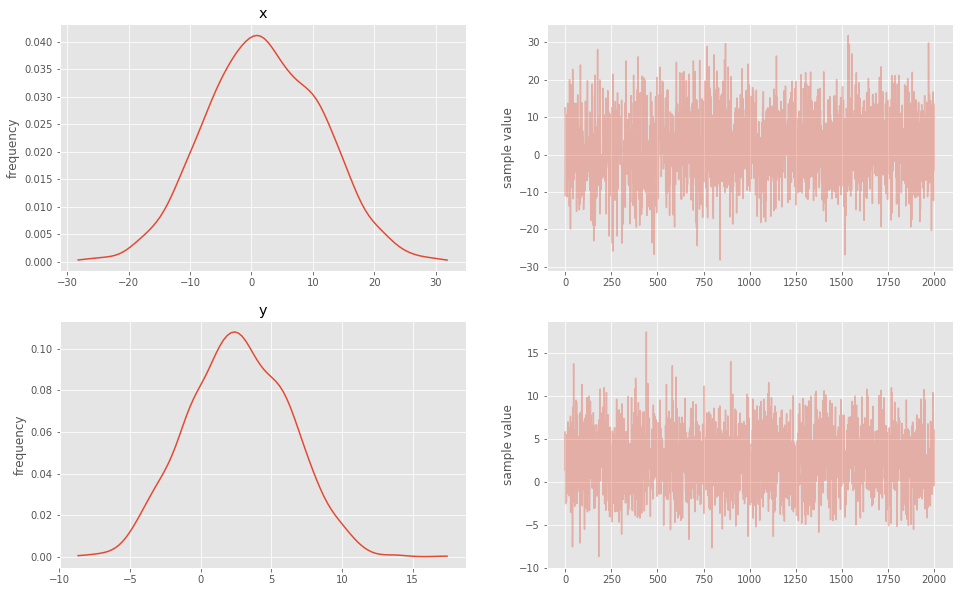

In [32]:
fit.traceplot();

In [33]:
fit.data

{'N': 8, 'a': array([1. , 3.1, 3.4, 6.7, 4. , 0. , 1.1, 2. ])}

## 2 Your first STAN model


### 2.1 The cyclist problem

Let's do the cyclist problem from the lecture slides: We have a dataset of observations (travel times of bicycle trips), and we want to estimate its distribution, assuming it follows a Gaussian curve of some form. 



As detailed in the lecture slides, you can code your STAN model directly into a Python string


In [34]:
cyclist_STAN="""
data {
    int<lower=0> N; // number of samples
    vector[N] tt;   // observed travel times
}
parameters {
    real at;          // average travel time
    real<lower=0> tu; // traffic uncertainty
}
model {
    at ~ normal(12, 10);
    tu ~ cauchy(0, 10);
    tt ~ normal(at, tu);
}
"""

# compile model
sm = pystan.StanModel(model_code=cyclist_STAN)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ccb3819b279763841816de16b66e504d NOW.


It is always good to have an intuitive notion of the prior forms (e.g. are they "too" informative, maybe? Or too wide?)

Can you plot the priors for _at_ and _tu_?

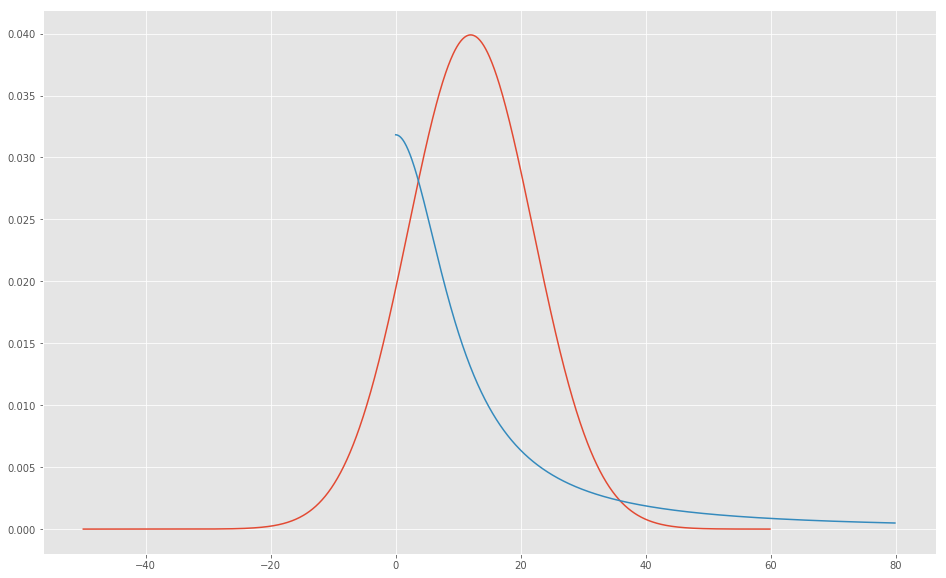

In [18]:
from scipy.stats import cauchy, norm

x1=np.arange(-50, 60, 0.1)
x2=np.arange(0, 80, 0.1)

y1=norm.pdf(x1, 12, 10)
y2=cauchy.pdf(x2, 0, 10)

plt.plot(x1, y1)
plt.plot(x2, y2)

Given what we know of the problem, do they make sense? 




Below is the Python code that calls for the STAN code above. 

In [35]:
# store data in python dictionary
cyclist_dat = {'N': 14,
               'tt': [13,17,16,32,12,13,28,12,14,18,36,16,16,31]}

# run inference
fit = sm.sampling(data=cyclist_dat, algorithm="NUTS", seed=0, iter=1000)

# show results
print(fit)

# extract samples
samples = fit.extract(permuted=True)

Inference for Stan model: anon_model_ccb3819b279763841816de16b66e504d.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
at    19.13    0.07   2.44  14.17  17.55  19.23  20.71   24.0   1131    1.0
tu     8.99    0.05   1.88    6.2   7.61   8.74  10.09  13.09   1220    1.0
lp__ -35.98    0.04   1.08 -38.87 -36.41 -35.66 -35.21 -34.89    763    1.0

Samples were drawn using NUTS at Fri Feb 23 11:05:50 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


The resulting MCMC samples that you get are in the "samples" object that we created above to collect all fit.extract() data. Try to **inspect** it, particularly do a histogram for the "at" and "tu" variables.

Check how many samples you have, and relate the number with the statistics that STAN provides above:
- How many samples did it actually generate?
- How many is it using for the final statistics?
- How many chains is it using (and how many samples being used in the end by each chain?)



2000


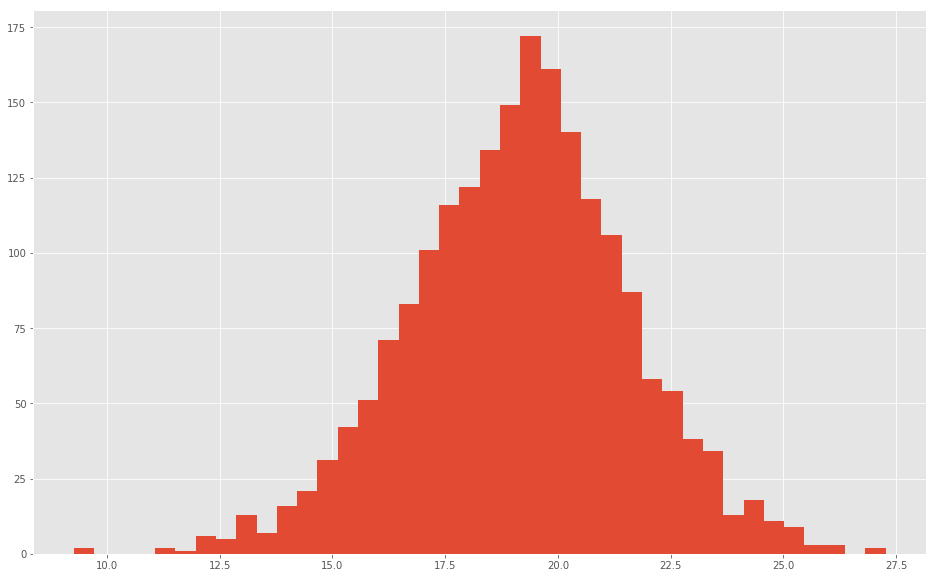

In [36]:
print(len(samples['at']))
plt.hist(samples['at'], bins=40);

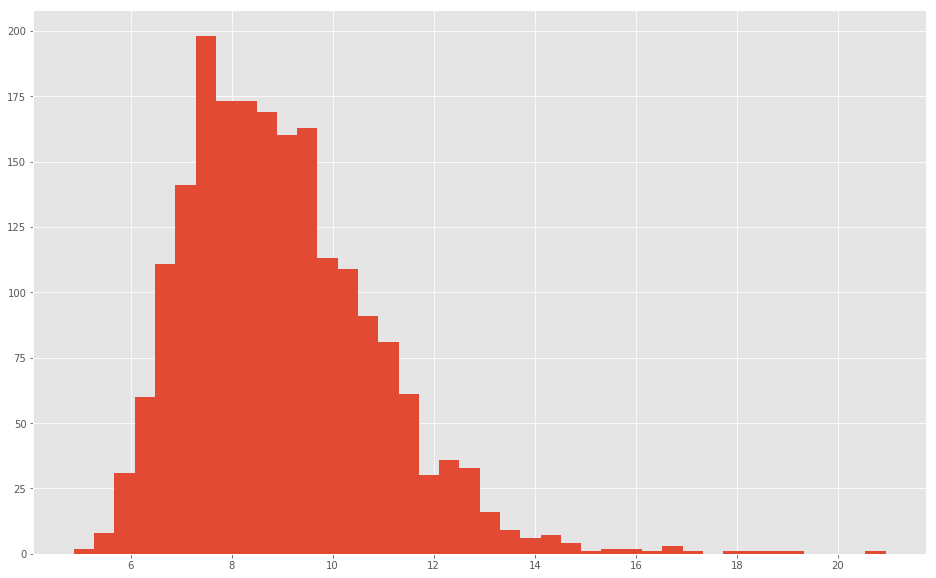

In [37]:
plt.hist(samples['tu'], bins=40);

To add to STAN's plot that you've used already, and we put some standard outout code here for you. ;-)


Averate travel time:
posterior mode=19.00 mean=19.13 std=2.44

Traffic uncertainty:
posterior mode=7.40 mean=8.99 std=1.88

Log marginal likelihood: -35.98044219971276


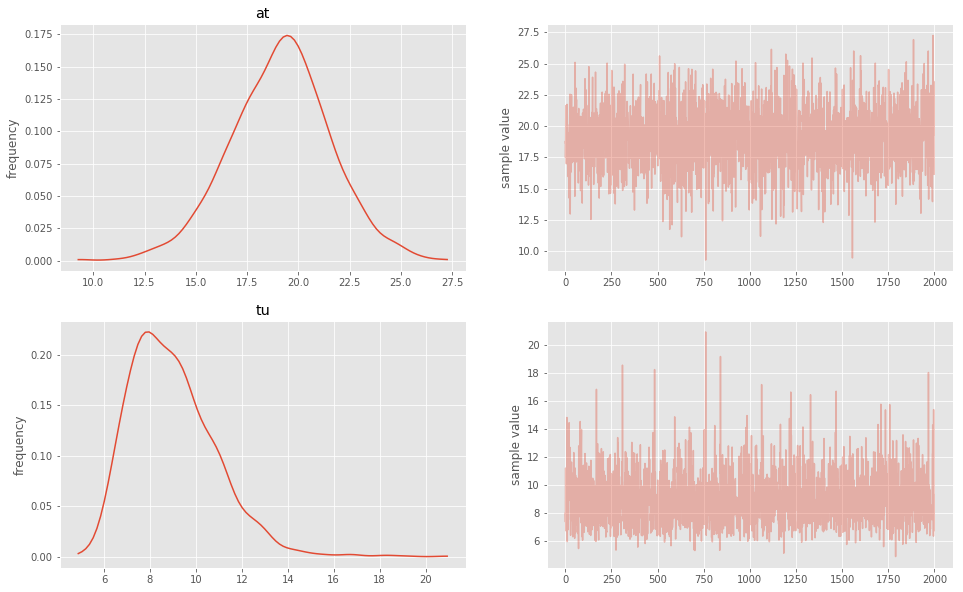

In [38]:
from scipy import stats

print("\nAverage travel time:")
print("posterior mode=%.2f mean=%.2f std=%.2f" % (stats.mode(samples["at"].round(0))[0][0], samples['at'].mean(), samples['at'].std()))

print("\nTraffic uncertainty:")
print("posterior mode=%.2f mean=%.2f std=%.2f" % (stats.mode(samples["tu"].round(1))[0][0], samples['tu'].mean(), samples['tu'].std()))

print ("\nLog marginal likelihood:", samples["lp__"].mean())

fit.plot()
plt.show()

**note:** the concept of "Log marginal likelihood" corresponds to the marginal probability of all data (denominator in Bayes formula)



Redefine the priors above and re-estimate the model (try only a couple of extreme values, just to see the effect)

### 2.2 Obtaining useful results from your model

Using the generated MCMC samples, you can find some useful answers.  For example, can you calculate the probability that the next trip takes less than 18 minutes?

In [24]:
n_samples=1000
means=np.random.normal(samples['at'].mean(), samples['at'].std(), n_samples)
varis=np.random.normal(samples['tu'].mean(), samples['tu'].std(), n_samples)

In [32]:
count=0

for mu, st in zip(means, varis):
    tt=np.random.normal(mu, np.abs(st))
    if tt < 18:
        count+=1
        
print(count/n_samples)

0.429


Notice that the certainty of your answer depends on the number of samples... 

Alternatively, we can use the "generated quantities" block of the STAN program to compute this probability. Lets extend our previous STAN program with a "generated quantities" block to compute the probability that the next trip takes less than 18 minutes.

In [30]:
cyclist_STAN="""
data {
    int<lower=0> N; // number of samples
    vector[N] tt;   // observed travel times
}
parameters {
    real at;          // average travel time
    real<lower=0> tu; // traffic uncertainty
}
model {
    at ~ normal(12, 10);
    tu ~ cauchy(0, 10);
    tt ~ normal(at, tu);
}
generated quantities {
    real prediction;
    int<lower=0,upper=1> is_less;    
    
    prediction = normal_rng(at, tu); // make prediction
    if (prediction < 18)             // check if prediction is less then 18
        is_less = 1;
    else
        is_less = 0;
}
"""

# compile model
sm = pystan.StanModel(model_code=cyclist_STAN)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b009099cbcdad1e0b97531c32d5b16e4 NOW.


Analyse the code above carefully. 

Notice how the "generated quantities" follows closely the generative process to sample observed travel times (predictions).

Run inference given some observed data:

In [31]:
# store data in python dictionary
cyclist_dat = {'N': 14,
               'tt': [13,17,16,32,12,13,28,12,14,18,36,16,16,31]}

# run inference
fit = sm.sampling(data=cyclist_dat, algorithm="NUTS", seed=0, iter=1000)

# show results
print(fit)

Inference for Stan model: anon_model_b009099cbcdad1e0b97531c32d5b16e4.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
at          19.13    0.07   2.37  14.43  17.55  19.17   20.7  23.65   1201    1.0
tu           8.84    0.06   1.83   6.17   7.59   8.57   9.74  13.41   1003    1.0
prediction  19.05    0.21   9.12   0.47   13.3  19.19  24.87  36.52   1912    1.0
is_less      0.44    0.01    0.5    0.0    0.0    0.0    1.0    1.0   2000    1.0
lp__       -35.91    0.03   1.03 -38.75  -36.3 -35.58 -35.17  -34.9    892    1.0

Samples were drawn using NUTS at Thu Feb 22 14:44:59 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Did you get a similar result?

### 2.3 Revised cyclist model: mixture model

We will now consider a more realistic model. Since sometimes cyclists are prone to extraordinary circumstances (e.g. flat tire, forgot something at home, ran into a friend and started chatting, etc.), the distribution of travel times can be bimodal, such that on certain days ("abnormal" days) the distribution of travel times is radically different the distribution of "normal" days. 

We will formulate this assumption as mixture of two Gaussians. 

Can you write the new (revised) model in STAN?

Hints:
- We will now have two Gaussians instead of one;
- We need a mixture parameter $\pi$ (real parameter between 0 and 1) that controls the mixing proportions of the two Gaussians (see lecture slides);
- The likelihood is now of the form: 

$\pi \, \mathcal{N}(at_o,tu_o) + (1-\pi) \, \mathcal{N}(at_a,tu_a)$

We can encode the likelihood in STAN using the function "log_mix()" as follows:

```python
for (n in 1:N)
    target += log_mix(pi, normal_log(tt[n], at_o, tu_o), normal_log(tt[n], at_a, tu_a));
```

In [41]:
cyclist_STAN_mixture = """
data {
    int<lower=0> N; // number of samples
    vector[N] tt;   // observed travel times
}
parameters {
    real at_o;          // average travel time for ordinary trips
    real<lower=0> tu_o; // traffic uncertainty for ordinary trips
    real at_a;          // average travel time for abnormal trips
    real<lower=0> tu_a; // traffic uncertainty for abnormal trips
    real<lower=0,upper=1> pi;   // mixing proportion
}
model {
    at_o ~ normal(10, 10);
    tu_o ~ cauchy(0, 10);
    at_a ~ normal(20, 10);
    tu_a ~ cauchy(0, 10);
    for (n in 1:N)
        target += log_mix(pi,
                        normal_log(tt[n], at_o, tu_o),
                        normal_log(tt[n], at_a, tu_a));
}
"""

# compile model
sm = pystan.StanModel(model_code=cyclist_STAN_mixture)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5ce58244380af54307726cafaa47d5b9 NOW.


Lets run inference on the revised model using the same cyclist data from before:

In [42]:
# store data in python dictionary
cyclist_dat = {'N': 14,
               'tt': [13,17,16,32,12,13,28,12,14,18,36,16,16,31]}

# run inference
fit = sm.sampling(data=cyclist_dat, algorithm="NUTS", seed=0, chains=1, iter=1000)

# show results
print(fit)

# extract samples
samples = fit.extract(permuted=True)

Inference for Stan model: anon_model_5ce58244380af54307726cafaa47d5b9.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
at_o  14.32    0.27   1.83   8.77  13.81   14.5  15.25   16.6     45   1.03
tu_o    2.9    0.27   2.06   1.45   2.03   2.46    3.1    7.8     60   1.02
at_a  28.77    0.57   4.44  17.99  26.79  29.96  31.72  35.22     61   1.02
tu_a   6.64    0.36   4.28    2.2   3.64   5.42   8.42  16.72    138   1.01
pi     0.62    0.02   0.18   0.09   0.55   0.65   0.75   0.89     81   1.02
lp__  -43.9    0.32   2.46 -50.01 -44.86 -43.25 -42.16 -40.93     60   1.04

Samples were drawn using NUTS at Thu Feb 22 16:03:17 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Look at the results. What can you tell?

### 2.4 Obtaining useful results from your revised model

As you did for the previous model with a single Gaussian, can you compute the probability that the next trip takes less than 18 minutes (given the new and more realistic model)?

In [33]:
cyclist_STAN_mixture = """
data {
    int<lower=0> N; // number of samples
    vector[N] tt;   // observed travel times
}
parameters {
    real at_o;          // average travel time for ordinary trips
    real<lower=0> tu_o; // traffic uncertainty for ordinary trips
    real at_a;          // average travel time for abnormal trips
    real<lower=0> tu_a; // traffic uncertainty for abnormal trips
    real<lower=0,upper=1> pi;   // mixing proportion
}
model {
    at_o ~ normal(10, 10);
    tu_o ~ cauchy(0, 10);
    at_a ~ normal(20, 10);
    tu_a ~ cauchy(0, 10);
    for (n in 1:N)
        target += log_mix(pi,
                        normal_log(tt[n], at_o, tu_o),
                        normal_log(tt[n], at_a, tu_a));
}
generated quantities {
    real prediction;
    int<lower=0,upper=1> is_ordinary_day;
    int<lower=0,upper=1> is_less;
    is_ordinary_day = bernoulli_rng(pi);     // decide if it is a ordinary day
    if (is_ordinary_day == 1)
        prediction = normal_rng(at_o, tu_o); // make prediction for ordinary day
    else
        prediction = normal_rng(at_a, tu_a); // make prediction for abnormal day
    if (prediction < 18)                     // check if prediction is less then 18
        is_less = 1;
    else
        is_less = 0;
}
"""

# compile model
sm = pystan.StanModel(model_code=cyclist_STAN_mixture)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_baa9be0c0671782bb3b6063eca752146 NOW.


Lets run inference on the model and check our answer:

In [34]:
# store data in python dictionary
cyclist_dat = {'N': 14,
               'tt': [13,17,16,32,12,13,28,12,14,18,36,16,16,31]}

# run inference
fit = sm.sampling(data=cyclist_dat, algorithm="NUTS", seed=0, iter=1000)

# show results
print(fit)

Inference for Stan model: anon_model_baa9be0c0671782bb3b6063eca752146.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
at_o             18.25    3.62   6.27  12.85  14.33  15.07  21.26  32.62      3   1.95
tu_o              4.31    1.58   3.87   1.53   2.13   2.71   4.71  15.91      6   1.23
at_a             25.09    4.39    7.6  13.48  15.48  28.11  31.45  34.85      3   1.77
tu_a              5.26    1.19   3.77   1.59   2.62   3.96   6.91  15.01     10   1.11
pi                0.58     0.1   0.19   0.19   0.43   0.61   0.73   0.87      4   1.34
prediction       19.29     0.2    9.1   8.58  13.69   16.1   24.7  39.68   2000    1.0
is_ordinary_day   0.57    0.08    0.5    0.0    0.0    1.0    1.0    1.0     34   1.04
is_less           0.63    0.01   0.48    0.0    0.0    1.0    1.0    1.0   2000    1.0
lp__            -44.05    0.27

Did you notice how different the answer when compared to previous model (single Gaussian)? Which one makes more sense to you? 

## Part 2 -  Mixture model

We know that by know you think you've had enough about Mixture Models... but in fact, there's (even) much more to it! :-)

For example, your well-known K-Means clustering algorithm is in fact a special case of a mixture model. 

Let's create a dataset with 400 samples that are distributed around 4 centers with 0.6 standard deviation. We will use the function [`make_blobs` ](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html)that generates isotropic Gaussian blobs for clustering.

In [35]:
# Generate some data
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=100, centers=2, cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

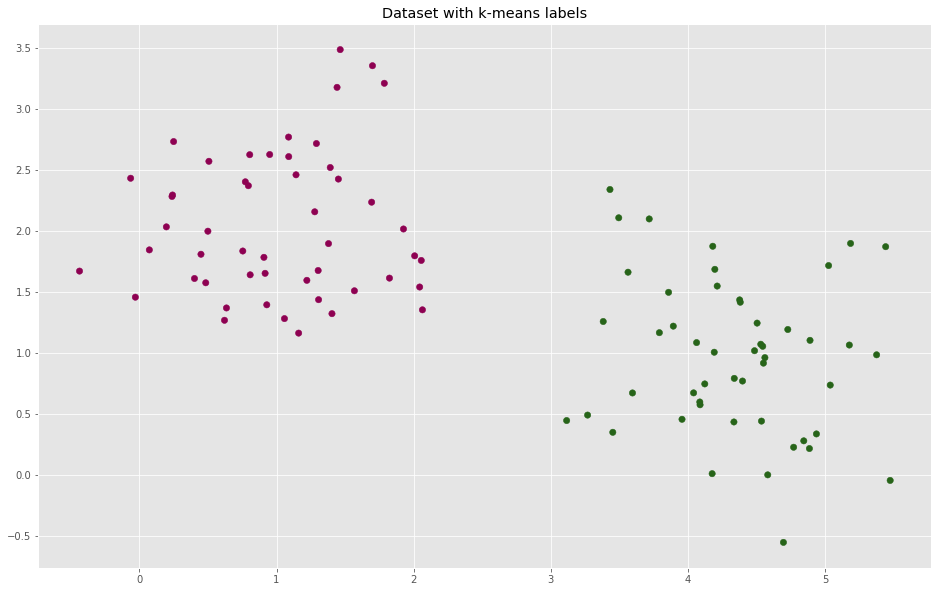

In [36]:
# Plot the data with K Means Labels
from sklearn.cluster import KMeans
kmeans = KMeans(2, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='PiYG')
plt.title('Dataset with k-means labels');

Let's look at their centers

In [37]:
kmeans.cluster_centers_

array([[1.0168431 , 2.04544835],
       [4.32924029, 0.96079228]])

It's time for our STAN GMM model. Get ready...

Study the code carefully

In [38]:
GMM_STAN="""
data {
    int<lower=0> D;  // number of dimensions
    int<lower=0> N;  // number of samples
    vector[D] X[N] ; // observed points
    int<lower=0> K;  //number of clusters
}

parameters {
    simplex[K] theta;             // mixing proportions
    vector[D] mu[K];              // mixture component means
    vector<lower=0>[D] sigma[K];  // covariance matrices
}
model {
    vector[K] log_theta = log(theta);  // cache log calculation
    
    for (k in 1:K){
        mu[k] ~ normal(0, 10);
        sigma[k] ~ cauchy(0, 10);
    }
    
    for (n in 1:N) {
        vector[K] lps = log_theta;
        for (k in 1:K)
            lps[k] += normal_lpdf(X[n] | mu[k], sigma[k]);
        target += log_sum_exp(lps);
    }
}
"""

# compile model
sm = pystan.StanModel(model_code=GMM_STAN)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a720004281f7ad25ad24675096d66132 NOW.


Inspect carefully the following code too. Particularly, notice that we're running with a single chain and 4000 iterations, instead of the default (chains=4, iterations=1000). Why would that be? 

To answer this question, run this code and check the results (compare with the centers above).

In [39]:
K=2
N=len(X)
D=2

data={'X':X, 'N': N, 'K':K, 'D':2}

# run inference
fit = sm.sampling(data=data, algorithm="NUTS", chains=1, seed=0, iter=4000)

# show results
print(fit)

Inference for Stan model: anon_model_a720004281f7ad25ad24675096d66132.
1 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=2000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[0]      0.5  1.1e-3   0.05   0.41   0.47    0.5   0.53   0.59   2000    1.0
theta[1]      0.5  1.1e-3   0.05   0.41   0.47    0.5   0.53   0.59   2000    1.0
mu[0,0]      1.02  2.2e-3    0.1   0.83   0.96   1.02   1.09   1.22   2000    1.0
mu[1,0]      4.33  1.9e-3   0.08   4.17   4.27   4.33   4.39   4.49   2000    1.0
mu[0,1]      2.05  3.1e-3   0.09   1.87   1.99   2.05   2.11   2.21    804    1.0
mu[1,1]      0.96  2.1e-3    0.1   0.76    0.9   0.96   1.02   1.16   2000    1.0
sigma[0,0]   0.65  2.1e-3   0.07   0.52   0.59   0.64   0.69   0.81   1201    1.0
sigma[1,0]    0.6  1.5e-3   0.07   0.49   0.55   0.59   0.64   0.74   2000    1.0
sigma[0,1]   0.61  2.9e-3   0.06    0.5   0.57    0.6   0.65   0.75    45

/Users/fmpr/anaconda/envs/stan/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Now, try to put the default values (chains=4, iterations=1000). What's the problem? 


Create and test a new version of the code above with higher K (e.g. K=3). 